In [496]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import numpy as np
import torch.optim
import matplotlib.pyplot as plt
import torch.autograd

We create our training and test data:

In [ ]:
mesh = torch.linspace(0,2*np.pi,201)
cos_mesh = torch.cos(mesh)
dataset = torch.stack((mesh,cos_mesh))
nb_train = int(dataset.shape[1] *0.8)
data_train = dataset[:,:nb_train]
data_test = dataset[:,nb_train:]


Plot of the cosine function:

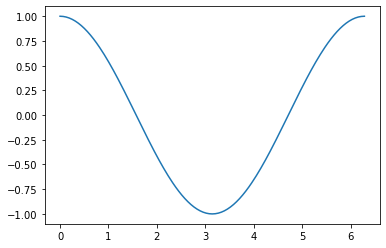

In [498]:
plt.plot(mesh,cos_mesh)
plt.show()

We define our inputs and labels in the getitem method:

In [499]:
class Cosine(Dataset):
    def __init__(self,dataset):
        super().__init__()

        self.dataset = dataset

    def __getitem__(self,idx):
        return self.dataset[0,idx], self.dataset[1,idx]


    def __len__(self):

        return self.dataset.shape[1]   


Regular Neural Network class:

In [500]:
class Neural_Net(nn.Module):
    def __init__(self,nb_layers,input_dim,latent_dim,output_dim,activation):
        super().__init__()

        self.nb_layers = nb_layers
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.activation = activation
        self.layers = nn.ModuleList([nn.Linear(input_dim,latent_dim)])
        for i in range(self.nb_layers-1):
            self.layers.append(nn.Linear(latent_dim,latent_dim))

        self.last_layer = nn.Linear(latent_dim,output_dim)    

    def forward(self,x):

        inputs = [x]
        for j in range(self.nb_layers):
            a = self.layers[j](inputs[j])
            """do not forget ACTIVATION FUNCTION!!!!!"""
            if j%2 == 0:
                b = self.activation[0](a)
            else:
                b = self.activation[1](a)    
            inputs.append(b)
        
        output = self.last_layer(inputs[-1])
        return output      


In [501]:
cos_train = Cosine(dataset=data_train)
cos_test = Cosine(dataset=data_test)
BATCH_SIZE = 25
N_EPOCHS = 2000
LR = 1e-3
INPUT_DIM = 1
LATENT_DIM = 20
OUTPUT_DIM = 1
activation = [nn.Tanh(),nn.Tanh()]
NB_LAYERS = 3
EVERY_EP = 200
ALPHA = 0.1

In [502]:
NN = Neural_Net(nb_layers=NB_LAYERS,input_dim=INPUT_DIM,latent_dim=LATENT_DIM,output_dim=OUTPUT_DIM,activation=activation)

In [503]:
optimizer = torch.optim.Adam(NN.parameters(),lr=LR)

In [504]:
train_loader = DataLoader(dataset=cos_train,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=cos_test,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)

We train our model:

In [505]:
loss_train = 0
l=torch.tensor([0.])
for epoch in range(N_EPOCHS):

    


    for n_batch,batch in enumerate(train_loader):
        x,labels = batch
        outputs = NN(x.view(BATCH_SIZE,INPUT_DIM))
        
        loss = torch.mean((outputs-labels.view(BATCH_SIZE,INPUT_DIM))**2)
           

        loss_train += loss.detach()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss_train /= (len(train_loader.dataset))
    loss_train *= BATCH_SIZE 
    
    loss_test = 0
    with torch.no_grad():
        for n_batch,batch in enumerate(test_loader):
            a,l =  batch 

            out = NN(a.view(BATCH_SIZE,INPUT_DIM))
            
            Loss = torch.mean((out-l)**2)    
            loss_test += Loss.detach()
        loss_test /= (len(test_loader.dataset)) 
        loss_test *= BATCH_SIZE       
        
        if epoch%EVERY_EP == 0:
            print(f"Epoch: {epoch} , Loss Train: {loss_train}, Loss Test: {loss_test}")






Epoch: 0 , Loss Train: 0.6340159773826599, Loss Test: 0.15560945868492126


Epoch: 200 , Loss Train: 0.0006150802364572883, Loss Test: 0.04078071936964989
Epoch: 400 , Loss Train: 3.398525223019533e-05, Loss Test: 0.049091700464487076
Epoch: 600 , Loss Train: 4.015390368294902e-05, Loss Test: 0.05077070742845535
Epoch: 800 , Loss Train: 1.1352333785907831e-05, Loss Test: 0.04775591194629669
Epoch: 1000 , Loss Train: 3.840624685835792e-06, Loss Test: 0.04609956219792366
Epoch: 1200 , Loss Train: 2.2738528059562668e-05, Loss Test: 0.045674607157707214
Epoch: 1400 , Loss Train: 0.0001378899032715708, Loss Test: 0.045214466750621796
Epoch: 1600 , Loss Train: 3.3095761864387896e-06, Loss Test: 0.044421423226594925
Epoch: 1800 , Loss Train: 1.1909870408999268e-05, Loss Test: 0.04379727318882942


We see here under that the model learns well on the training data, but does not have good performances on the test set.

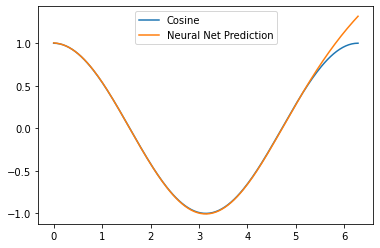

In [506]:
import matplotlib.pyplot as plt

grid = torch.linspace(0,2*np.pi,200).view(200,1)
cos_grid = torch.cos(grid)
y_prediction = NN(grid).detach()

plt.plot(grid,cos_grid,label='Cosine')
plt.plot(grid,y_prediction,label='Neural Net Prediction')
plt.legend()



We are now going to learn the Cosine function using a completely different method called

Physics-Informed Neural Networks: we see the Cosine function as the solution of the differential

equation y''+ y = 0 with initial conditions y(0) = 1 and y'(0) = 0.

In [507]:
Physics_NN = Neural_Net(nb_layers=2,input_dim=1,latent_dim=20,output_dim=1,activation=activation)

<ipython-input-512-9743f25be038>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.scatter(x.detach(),torch.cos(x.detach()),Color='g')


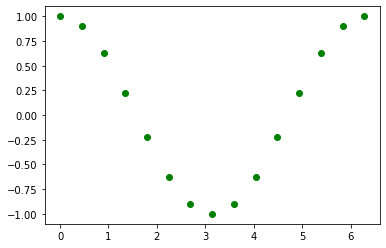

In [512]:
physics_optimizer = torch.optim.Adam(Physics_NN.parameters(),lr=LR)
epochs = 5000
nb_points = 15
x = torch.linspace(0,2*np.pi,nb_points).view(nb_points,1).requires_grad_()
plt.scatter(x.detach(),torch.cos(x.detach()),Color='g')


Here we implement the Physics-Informed Neural Networks by adding three losses:

one loss on the sum of the second derivative y'' and y, and two initial condition losses,

the goal is to minimize y''+ y , y(0)-1 , and y'(0) in order to get a prediction that

respects the differential equation.

In [509]:
for ep in range(epochs):
    
        
    y = Physics_NN(x)
    dy_dx = torch.autograd.grad(y,x,torch.ones_like(y),create_graph=True)[0] #first derivative of y w.r.t x
    
    dy_dxx = torch.autograd.grad(dy_dx,x,torch.ones_like(dy_dx),create_graph=True)[0] # second derivative of y w.r.t x
    loss_ic_y = (y[0]-1)**2   ### ic stands for initial condition, initial condition y(0) = 1
    loss_ic_dy = (dy_dx[0])**2   # initial condition on the first derivative y'(0) = 0
    loss_physics = (dy_dxx+y)**2    # we define y''+ y  
    loss = torch.mean(loss_ic_y + loss_ic_dy + loss_physics)
        
    loss.backward()
    physics_optimizer.step()  # we minimize the sum of loss_physics and the two ic's so that the Differential Equation loss is small and also the IC terms are small
    physics_optimizer.zero_grad()   
     

    if ep%100==0:
        print('loss_train',loss.item(),'epoch',ep)

    
    


    

loss_train 1.1131298542022705 epoch 0
loss_train 0.10218880325555801 epoch 100
loss_train 0.08144144713878632 epoch 200
loss_train 0.07179625332355499 epoch 300
loss_train 0.06024612858891487 epoch 400
loss_train 0.04881597310304642 epoch 500
loss_train 0.039725031703710556 epoch 600
loss_train 0.03405407443642616 epoch 700
loss_train 0.030407626181840897 epoch 800
loss_train 0.027672478929162025 epoch 900
loss_train 0.025304432958364487 epoch 1000
loss_train 0.023144222795963287 epoch 1100
loss_train 0.02114269882440567 epoch 1200
loss_train 0.019531147554516792 epoch 1300
loss_train 0.01845249906182289 epoch 1400
loss_train 0.017166947945952415 epoch 1500
loss_train 0.015485519543290138 epoch 1600
loss_train 0.013913593254983425 epoch 1700
loss_train 0.01277534756809473 epoch 1800
loss_train 0.011739267967641354 epoch 1900
loss_train 0.010632095858454704 epoch 2000
loss_train 0.009430063888430595 epoch 2100
loss_train 0.008122670464217663 epoch 2200
loss_train 0.006654481869190931 ep

In the beggining we only had 15 points. Below we sample more densely(500 points).

 we do not see any difference between the true Cosine function and the Neural Network prediction.

With only 15 'data' points, the Physics-Informed Neural Network method performs very well.

We do not need many points to obtain a good result (at least in dimension 1).

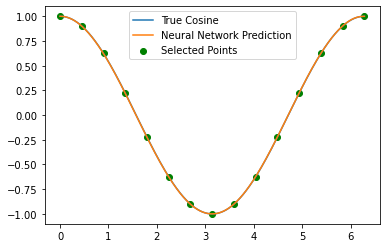

In [510]:
import matplotlib.pyplot as plt

grid = torch.linspace(0,2*np.pi,500).view(500,1).detach()

cos_grid = np.cos(grid)
physics_prediction = Physics_NN(grid).detach()
plt.scatter(x.detach(),torch.cos(x.detach()),color='g',label='Selected Points')
plt.plot(grid,cos_grid,label='True Cosine')
plt.plot(grid,physics_prediction,label='Neural Network Prediction')
plt.legend()

We can compute the Mean Squared Error between our NN prediction and the true solution:

the error is around 4e-6 which is very low.

In [513]:
print('Mean Square Error',criterion(physics_prediction,torch.cos(grid)).item())

Mean Square Error 3.947341610910371e-06
